
## Print figures of Himawari SST data in regions (distributed)


In [1]:
import os,sys
from glob import glob
#
import xarray as xr
from dask import compute, delayed
from dask.distributed import Client
# 
from datetime import datetime
#
from utils import *

/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/utils.py:121: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


satpy not available


/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
### get dask handles and check dask server status
client = Client(scheduler_file=os.path.expanduser('/home1/datawork/aponte/dask/scheduler.json'))
client.restart()
# upload utils.py to workers
client.upload_file('utils.py')

In [3]:
client

Client Scheduler: tcp://10.148.1.3:8786 Dashboard: http://10.148.1.3:8787,Cluster Workers: 62 Cores: 248 Memory: 620.00 GB


In [4]:
# data path
region = 'NWA'; vmin = 20.; vmax = 35.
region = 'NWAM'; vmin = 26.; vmax = 32.
region = 'WA'; vmin = 20.; vmax = 35.

#
dpath = '/home/datawork-lops-osi/data/hw/sst/'+region+'/';
figdir = '/home1/datawork/aponte/hw/figs/'

filenames = sorted(glob(dpath+region+'_*.nc'))
print('Number of files available: %d' %len(filenames))
Nfiles = len(filenames)
# tmp, subset number of files (skip last file that may be incomplete)
#filenames = filenames[:-1]

# consider a time subset
times = [datetime.strptime(f,dpath+region+'_%Y%m%d%H%M.nc') for f in filenames]
#
lat=None
#
if True:
    # NWAM
    #t1, t2, suff, vmin, vmax = datetime(2017,5,3), datetime(2017,5,7), '_t0', 27.5, 30.
    # WA
    #t1, t2, suff, vmin, vmax = datetime(2016,9,3), datetime(2016,9,16), '_t1', 20., 35.
    t1, t2, suff, vmin, vmax, slat = datetime(2016,9,3), datetime(2016,9,16), '_t1z', 23., 30., slice(-12,-24)
    #
    filenames  = [f for f,t in zip(filenames,times) if (t>t1) and (t<t2)]
else:
    suff = ''

print('Number of files processed: %d' %len(filenames))

Number of files available: 11340
Number of files processed: 1842


In [5]:

def process(f,i, overwrite, slat=None):
    #
    time = datetime.strptime(f,dpath+region+'_%Y%m%d%H%M.nc')
    figname = figdir+'hw_sst_'+region+'_'+time.strftime('%Y%m%d_%H%M')+suff+'.png'
    #
    if not os.path.isfile(figname) or overwrite:
        # open file
        sst = xr.open_dataset(f)['sea_surface_temperature'].isel(time=0)-273.15
        if slat is not None:
            sst = sst.sel(lat=slat)
        #
        title = time.strftime('%Y%m%d_%H%M')
        plot_sst(sst, colorbar=False, title=title, savefig=figname, vmin=vmin, vmax=vmax, offline=True, coast_resolution='50m', figsize=(15,10))
        #
        m = float(sst.mean().values)
    else:
        m = -1.
    #
    return m


In [6]:
# computation starts here
#values = [delayed(process)(f,i, True) for i,f in enumerate(filenames[:])]
values = [delayed(process)(f,i, True, slat=slat) for i,f in enumerate(filenames[:])]
results = compute(*values, get=client.get)

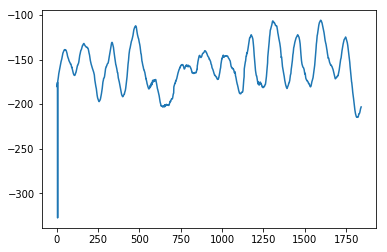

In [7]:
# plot first days of domain averaged values
import matplotlib.pyplot as plt
plt.figure()
plt.plot(results[:])
plt.show()

In [8]:
# make movie
print('ffmpeg -y -r 10 -pattern_type glob -i  \''+figdir+'hw_sst_'+region+'*'+suff+'.png\'  hw_sst_'+region+suff+'.mp4')

ffmpeg -y -r 10 -pattern_type glob -i  '/home1/datawork/aponte/hw/figs/hw_sst_WA*_t1z.png'  hw_sst_WA_t1z.mp4
